**Problem 3**

In [1]:

# Useful additional packages 
import matplotlib.pyplot as plt
import numpy as np
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
import torch




"""
q = QuantumRegister(2)

qc = QuantumCircuit(q)
qc.u(pi,0,pi,q[0])
qc.draw()
"""


#lets create GHZ state
circ = QuantumCircuit(3)
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)
# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**3)
state1 = state.copy()
# Evolve the state by the quantum circuit
state = state.evolve(circ)
print(state)
print(state1)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [2]:
#function that apply the KS test to two probability list
def KS(P1, P2):
    assert len(P1) == len(P2)
    cdf1 = [P1[0]]
    cdf2 = [P2[0]]
    for i in range(len(P1)-1):
        cdf1.append(cdf1[i] + P1[i+1])
        cdf2.append(cdf2[i] + P2[i+1])
    difference = torch.tensor(cdf1) - torch.tensor(cdf2)
    #print(difference)
    return difference.abs().max().item()

print(KS([0.2, 0.8], [0.5, 0.5]))

0.30000001192092896


In [3]:
q = QuantumRegister(3)
qc = QuantumCircuit(q)
qc.u(0.5,0,pi,q[0])
qc.u(0.5,0,pi,q[1])
qc.u(0.5,0,pi,q[2])

In [4]:
import torch
print(torch.randn(2,2))

tensor([[ 0.9960,  0.5384],
        [-1.4568,  0.1620]])


Current Parameters:  tensor([[3.1102, 0.0314, 2.5133],
        [1.3823, 2.5761, 2.5761],
        [2.9845, 2.9217, 1.7907]])
Current Transformation:
tensor([[ 0.0157+0.0000j,  0.8089+0.5877j],
        [ 0.9994+0.0314j, -0.0130+0.0088j]])
tensor([[ 0.7705+0.0000j,  0.5382+0.3415j],
        [-0.5382+0.3415j,  0.3281-0.6972j]])
tensor([[ 7.8459e-02+0.0000j,  2.1747e-01+0.9729j],
        [-9.7291e-01+0.2175j,  9.3561e-10-0.0785j]])


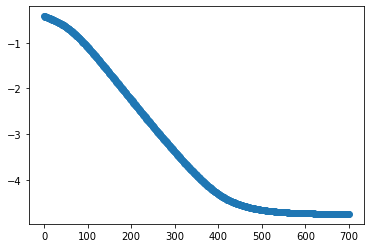

Current Parameters:  tensor([[ 3.1360, -0.2441,  2.7472],
        [ 3.1358,  2.0417,  2.8100],
        [ 3.1366,  2.6427,  2.0246]])
 
Current Transformation:
tensor([[ 0.0028+0.0000j,  0.9232+0.3843j],
        [ 0.9703-0.2417j, -0.0022+0.0017j]])
tensor([[ 2.9039e-03+0.0000j,  9.4553e-01+0.3255j],
        [-4.5365e-01+0.8912j,  4.0316e-04-0.0029j]])
tensor([[ 2.5002e-03+0.0000j,  4.3840e-01+0.8988j],
        [-8.7810e-01+0.4785j, -1.1269e-04-0.0025j]])
 
New vs Original State Vector:
Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
Statevector([-1.90079283e-01-6.81071706e-01j,
              9.73578179e-04+1.70516403e-03j,
             -2.01517118e-03-4.00944098e-04j,
             -3.91761220e-04+1.72241480e-03j,
             -1.23708114e-03-1.26516853e-03j,
             -1.50797692e-03+1.39170582e-03j,
             -5.99307712e-05-1.9598509

In [18]:
#this is where we try to learn the symmetry


class SymFinder():
  def __init__(self, eta, step_size):
    self.parameters = torch.randint(0, 100, (3, 3)) * pi /100
    #parameters[i,0] is the theta for ith qubit, 1 is \phi, 2 is lambda
    self.original_state = state
    self.transformed_state = None
    self.lr = eta
    self.reg = 10 # this is regularizer's coefficient.
    self.step_size = step_size
    self.losses = []

  
  #return a transformed state according to parameter
  def transform(self, p):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(p[0,0].item(),p[0,1].item(),p[0,2].item(),q[0])
    qc.u(p[1,0].item(),p[1,1].item(),p[1,2].item(),q[1])
    qc.u(p[2,0].item(),p[2,1].item(),p[2,2].item(),q[2])
    return self.original_state.copy().evolve(qc)


  
  def change_basis(self, state1, state2):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(pi/2, 0, 0, q[0])
    qc.u(pi/2, 0, 0, q[1])
    qc.u(pi/2, 0, 0, q[2])
    return state1.copy().evolve(qc), state2.copy().evolve(qc)

  #return the loss from KS test of original vs another state
  def calculate_loss(self, state2):
    #get the probability in the original basis
    P1 = self.original_state.probabilities()
    P2 = state2.probabilities()
    #now we calculate probability in another basis
    new_state1, new_state2 = self.change_basis(self.original_state, state2)
    Q1 = new_state1.probabilities()
    Q2 = new_state2.probabilities()
    #lets add regularizer, punish u0 last coefficient being absolute value 1.
    a = torch.abs(self.current_matrix()[0][1,1])
    #print(a)
    v = torch.exp(-(a-1)**2) * self.reg
    #print(a, v)
    return [KS(P1, P2) + KS(Q1, Q2) + v, KS(P1, P2) + KS(Q1, Q2)]
  
    
  def update(self):
    #calculate the gradient using good old finite difference:
    cur_state = self.transform(self.parameters)
    cur_loss = self.calculate_loss(cur_state)[0]
    grad = torch.zeros(3,3)
    for i in range(3):
        for j in range(3):
            new_param = self.parameters.clone()
            new_param[i,j] = new_param[i,j] + self.step_size
            new_state = self.transform(new_param)
            new_loss = self.calculate_loss(new_state)[0]
            grad[i,j] = (new_loss - cur_loss) / self.step_size
    #update the parameters:
    self.parameters = self.parameters - self.lr * grad
    #self.parameters[:, 2] = torch.zeros(3)
    return self.calculate_loss(cur_state)[1]

  def current_matrix(self):
    p = self.parameters
    #p[0,:] = torch.tensor([3.14159, 0,3.1415926])
    u0 = torch.tensor([[torch.cos(p[0,0]/2), -torch.exp(-p[0,2]*1j)*torch.sin(p[0,0]/2)],\
                    [torch.exp(p[0,1]*1j)*torch.sin(p[0,0]/2), torch.exp((p[0,1] + p[0,2])*1j)*torch.cos(p[0,0]/2)]])
    u1 = torch.tensor([[torch.cos(p[1,0]/2), -torch.exp(-p[1,2]*1j)*torch.sin(p[1,0]/2)],\
                    [torch.exp(p[1,1]*1j)*torch.sin(p[1,0]/2), torch.exp((p[1,1] + p[1,2])*1j)*torch.cos(p[1,0]/2)]])
    u2 = torch.tensor([[torch.cos(p[2,0]/2), -torch.exp(-p[2,2]*1j)*torch.sin(p[2,0]/2)],\
                    [torch.exp(p[2,1]*1j)*torch.sin(p[2,0]/2), torch.exp((p[2,1] + p[2,2])*1j)*torch.cos(p[2,0]/2)]])
    return [u0, u1, u2]
        
        
        
        
        
  def train(self):
    for i in range(700):
      self.losses.append(self.update())
      #print(self.losses[i])



model = SymFinder(0.05, 0.01)
#model.parameters = torch.tensor([[pi, 0, 3.0], [pi, 0, pi], [pi, 0, pi]])

print("Current Parameters: ", model.parameters)

print("Current Transformation:")
print(model.current_matrix()[0])
print(model.current_matrix()[1])
print(model.current_matrix()[2])



model.train()

import numpy as np

plt.scatter(range(len(model.losses)), np.log10(model.losses))
#plt.scatter(range(len(model.losses)), model.losses)
plt.show()

print("Current Parameters: ", model.parameters)
print(" ")
print("Current Transformation:")
print(model.current_matrix()[0])
print(model.current_matrix()[1])
print(model.current_matrix()[2])
print(" ")
print("New vs Original State Vector:")
print(model.original_state)
print(model.transform(model.parameters))

  

  
  
  

  


In [61]:
import numpy as np

print(torch.pow(model.current_matrix()[2][:,0].abs(), 2).sum())
print(model.current_matrix()[0][1,1] * model.current_matrix()[1][1,1] * model.current_matrix()[2][1,1])


#plt.scatter(range(len(model.losses)), np.log10(model.losses))

tensor(1.0000)
tensor(1.0000-0.0024j)


In [33]:
print(torch.exp(torch.tensor([3+3j]))

SyntaxError: unexpected EOF while parsing (<ipython-input-33-31d575f077ea>, line 1)